In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, LayerNormalization, Concatenate, Dropout, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np




import os
import glob

In [3]:
# network parameters
width = 32
height = 32
latent_dim = 100



def build_generator():
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_latent')



    x = Dense(4*4*256)(latent_inputs)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Reshape((4,4,256))(x)


    x = UpSampling2D()(x)
    x = Conv2D(128,3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(64,3, strides=1, padding='same')(x)    
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(32,3, strides=1, padding='same')(x)    
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    img_outputs = Conv2D(3,5, strides=1, activation='tanh', padding='same')(x)


    return Model(latent_inputs, img_outputs, name='generator')

generator = build_generator()
generator.summary()








Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_latent (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         29

In [4]:
def build_discriminator():
    inputs = Input(shape=(width,height,3), name='discriminator_input')
    
    

    
    x = Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(258, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Flatten()(x)

    valid = Dense(1)(x)



    return Model(inputs, valid, name='discriminator')
build_discriminator().summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
layer_normalization (LayerNo (None, 16, 16, 64)        128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
layer_normalization_1 (Layer (None, 8, 8, 128)         256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)       

In [5]:
def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [6]:
df = pd.read_csv('./celeba-attribs.csv')

In [7]:
training_data_generator = ImageDataGenerator(
    validation_split=0.2,
    horizontal_flip=False,
    preprocessing_function=normalize_for_tanh)


training_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(32, 32),
    subset='training',
    shuffle=True,
    batch_size=162080,
    class_mode='raw')

Found 162080 validated image filenames.


In [8]:
def encode_to_attribs(encoded):
    for present, attrib in zip(encoded, list(df.columns[1:])):
        if present > 0:
            print(attrib, present)

In [9]:
def attribs_to_str(encoded):
    return "\n".join([" : ".join([ attrib,str(present)]) for (present, attrib) in zip(encoded, get_attribs()) if present > 0 or present < -1])


In [10]:
# load into memory (needs a substantial amount)
# batch if it doesn't fit
training_data = training_generator.next()

In [12]:
generator = build_generator()
discriminator = build_discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

In [13]:
@tf.function
def train_step_generator():
    
    batch_size = 64
    latent_dim = 100
    
    with tf.GradientTape() as gen_tape:    
        

        
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=True)       
        

        # gan loss
        fake_output = discriminator(generated_images, training=False)
        gen_loss = -tf.reduce_mean(fake_output)
   
        generator_loss = gen_loss


    
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss



@tf.function
def train_step_discriminator(images):
    
    batch_size = 64
    latent_dim = 100
    gp_lambda = 10
    
    with tf.GradientTape() as disc_tape:
        # generate 
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=False)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated_images = generated_images * alpha + images * (1 - alpha)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            interpolated_output = discriminator(interpolated_images, training=True)
        gp_gradients = gp_tape.gradient(interpolated_output, interpolated_images)
        
        # l2 norm on all axis except batch
        gp_gradients_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_gradients), axis=[1,2,3]))
        gp = tf.reduce_mean(tf.square(gp_gradients_l2_norm-1))
        
        
        
        loss_real = tf.reduce_mean(real_output)
        loss_fake = tf.reduce_mean(fake_output)
        disc_loss = (loss_fake - loss_real) + gp_lambda * gp 
        
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return loss_real, loss_fake
    
        
        
        

In [ ]:
import time
from pathlib import Path

start_epoch = 1
epochs = 200000
batch_size = 64
checkpoint_every_n_epochs = 10000
figure_every_n_epochs = 5000
n_critic = 5



plt.ioff()

model_type = f'wgan-gp'
data_name = f'celeba'

#create base dir
base_model_path = Path(f'./model-data/{model_type}/{data_name}')
base_model_path.mkdir(parents=True, exist_ok=True)

#create figure dir
figure_model_path = base_model_path / 'figures'
figure_model_path.mkdir(parents=True, exist_ok=True)

#create checkpoint dir
checkpoints_model_path = base_model_path / 'checkpoints'
checkpoints_model_path.mkdir(parents=True, exist_ok=True)


with tf.device('gpu:0'):
    
    if start_epoch == 1:
        training_imgs = np.cast['float32'](training_data[0])
        num_batches = len(training_imgs) // batch_size
        # losses
        rl_lo_loss_list = [] 
        rl_med_loss_list = [] 
        rl_hi_loss_list = [] 
        kl_loss_list = []
        gen_loss_list = []
        disc_real_list = []
        disc_fake_list = []
        mu, sigma = 0, 1 #mean and standard deviation
        test_noise = np.random.normal(mu, sigma, (1,latent_dim))
    

    rl_lo_loss = 0
    rl_med_loss = 0
    rl_hi_loss = 0
    kl_loss = 0
    gen_loss = 0

    
    for epoch in range(1,epochs+1):
        start = time.time()
        print(f'Iteration [{epoch}/{epochs}]...'.ljust(20), end = '')
 

        
        disc_real_sum = 0
        disc_fake_sum = 0
        for _ in range(n_critic):
            idxs_batch = np.random.randint(0,len(training_imgs)-1,size=batch_size)
            img_batch = training_imgs[idxs_batch]
            disc_real, disc_fake = train_step_discriminator(img_batch)
            disc_real_sum += K.get_value(disc_real)
            disc_fake_sum += K.get_value(disc_fake)            
        
        
        gen_loss = train_step_generator()
        
        
        
        disc_real = disc_real_sum/n_critic
        disc_fake = disc_fake_sum/n_critic
        gen_loss = K.get_value(gen_loss)

        
        
        disc_real_list.append(disc_real)
        disc_fake_list.append(disc_fake)
        gen_loss_list.append(gen_loss)

        
        print(f'...{time.time()-start:.3f}(s) '  , end='')        
        
        print(f'gen: {gen_loss:.5f} - ', end='')
        print(f'disc_fake: {disc_fake:.5f} - ', end='')
        print(f'disc_real: {disc_real:.5f} - ', end='')
        print(f'disc_real: {disc_real - disc_fake:.5f}')


        

        if epoch % figure_every_n_epochs == 0:
            
             # plot fig for r - f to observe convergence
            negative_critic_loss = np.array(disc_real_list)-np.array(disc_fake_list)
            plt.plot(negative_critic_loss, label="negative_critic")
            plt.show()
            
            gen_img = unnormalize_tanh( generator.predict(test_noise)[0])        
            plt.imshow(gen_img.reshape(32,32,3))
            plt.title("Generated Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'generated-{epoch}.png')
            plt.show()


        if epoch % checkpoint_every_n_epochs == 0 and epoch != 0:        
            print(f'checkpointing at epoch: {epoch}')
            generator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator-weights.h5').as_posix())
            generator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator.h5').as_posix())
            discriminator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator-weights.h5').as_posix())
            discriminator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator.h5').as_posix())
            

C:\Users\Jose\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  import sys
C:\Users\Jose\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


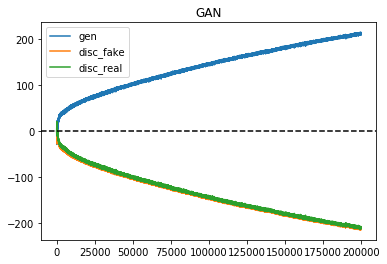

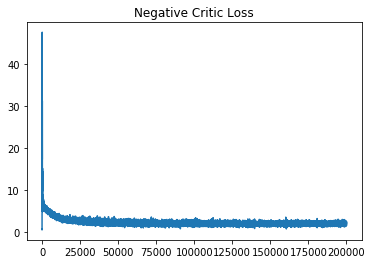

In [15]:


plt.plot(gen_loss_list, label="gen")
plt.plot(disc_fake_list, label="disc_fake")
plt.plot(disc_real_list, label="disc_real")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title("GAN")
plt.savefig(figure_model_path / 'gan.png')
plt.show()

negative_critic_loss  = np.array(disc_real_list)-np.array(disc_fake_list)
plt.plot(negative_critic_loss)
plt.title("Negative Critic Loss")
plt.savefig(figure_model_path / 'negative_critic.png')
plt.show()

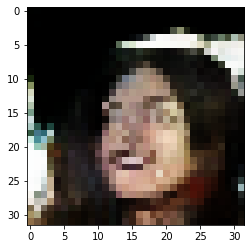

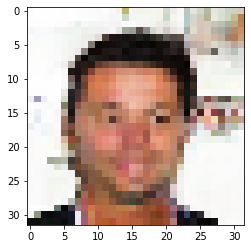

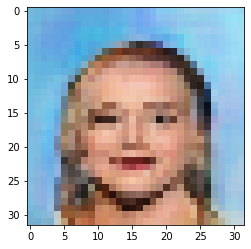

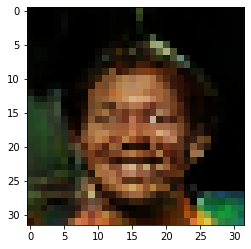

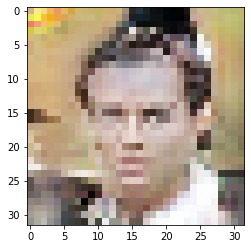

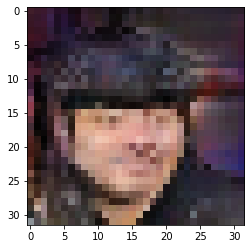

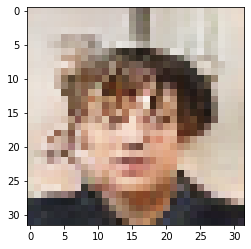

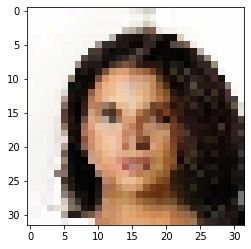

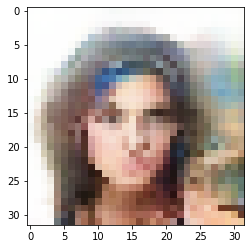

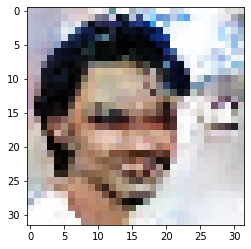

In [51]:
# Some sample generated faces
for i in range(10):
    noise = np.random.normal(0,1, (1,100))
    gen_img = unnormalize_tanh( generator.predict(noise)[0])        
    plt.imshow(gen_img.reshape(32,32,3))
    plt.show()

In [23]:
validation_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(32, 32),
    subset='validation',
    shuffle=True,
    batch_size=32,
    class_mode='raw')

Found 40519 validated image filenames.


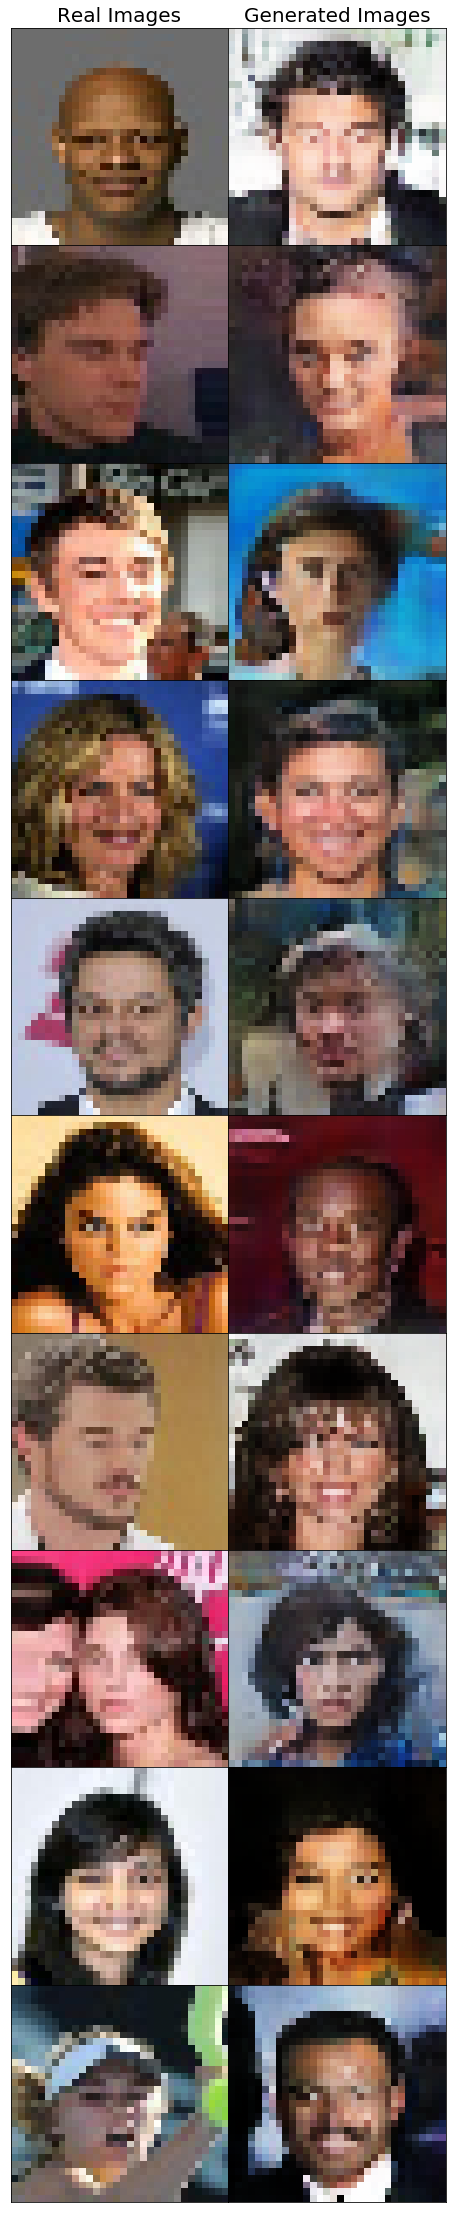

In [50]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(200., 40.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 2),  # creates 2x2 grid of axes
                 axes_pad=0.0,  # pad between axes in inch.
                 )

val_data = validation_generator.next()
for i in range(20):
    if i % 2 == 0:
        grid[i].imshow(unnormalize_tanh(val_data[0][i]))
        grid[i].set_xticks([])
        grid[i].set_yticks([])
    
    else:
        noise = np.random.normal(0,1, (1,100))
        gen_img = unnormalize_tanh( generator.predict(noise)[0])  
        grid[i].imshow(gen_img)
        grid[i].set_xticks([])
        grid[i].set_yticks([])
grid[0].set_title('Real Images', fontsize=20.)
grid[1].set_title('Generated Images', fontsize=20.)
plt.show()